In [2]:
import numpy as np

import matplotlib.pyplot as plt

import os
import pandas as pd
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.15.0


In [2]:
#try for mem allocation

# Get the list of available physical GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        # Set memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2024-03-14 22:54:52.922290: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:54:52.979412: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:54:52.979462: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:54:52.983832: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 22:54:52.983892: I external/local_xla/xla/stream_executor

In [3]:
import keras
root="BTdataset/Data/"
img_size=256
datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,  # Normalize pixel values
 # Specify multiple image formats
)

train_ds = datagen.flow_from_directory(
    root,
    target_size=(img_size, img_size),
    batch_size=8,
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    seed=1233,
    
)

val_ds = datagen.flow_from_directory(
    root,
    target_size=(img_size, img_size),
    batch_size=8,
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    seed=1233,
    
)


Found 2479 images belonging to 4 classes.
Found 617 images belonging to 4 classes.


In [4]:
class_indices = train_ds.class_indices
print(class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'normal': 2, 'pituitary_tumor': 3}


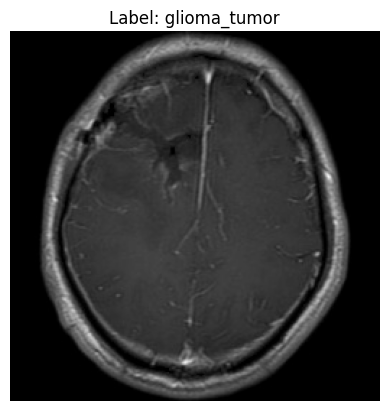

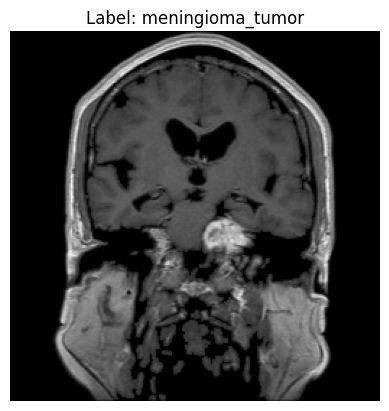

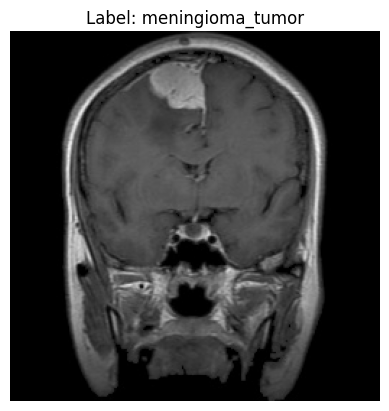

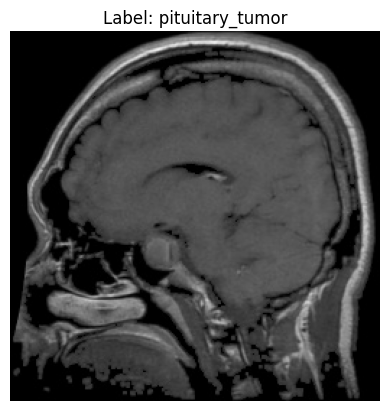

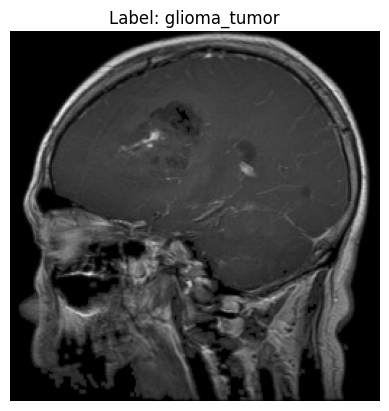

In [4]:
num_images_to_visualize = 5

# Get the class names
class_names = train_ds.class_indices
class_names = {v: k for k, v in class_names.items()}  # Invert the dictionary

for i in range(num_images_to_visualize):
    image, label = train_ds.next()  # Get the next batch of images and labels
    class_label = class_names[np.argmax(label[0])]  # Map the one-hot encoded label to class name
    plt.imshow(image[0].squeeze(), cmap='gray')
    plt.title(f"Label: {class_label}")  # Display the corresponding class name
    plt.axis('off')  # Turn off axis
    plt.show()  # Show the image


In [9]:
model = Sequential()

# 1 - conv
model.add(Conv2D(64,(3,3),padding='same',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 - conv
model.add(Conv2D(128,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2.1 - conv
model.add(Conv2D(256,(5,5),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
# 3 - conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 4 - conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 5 - conv
model.add(Conv2D(512,(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(4,activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 256, 256, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     2

In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


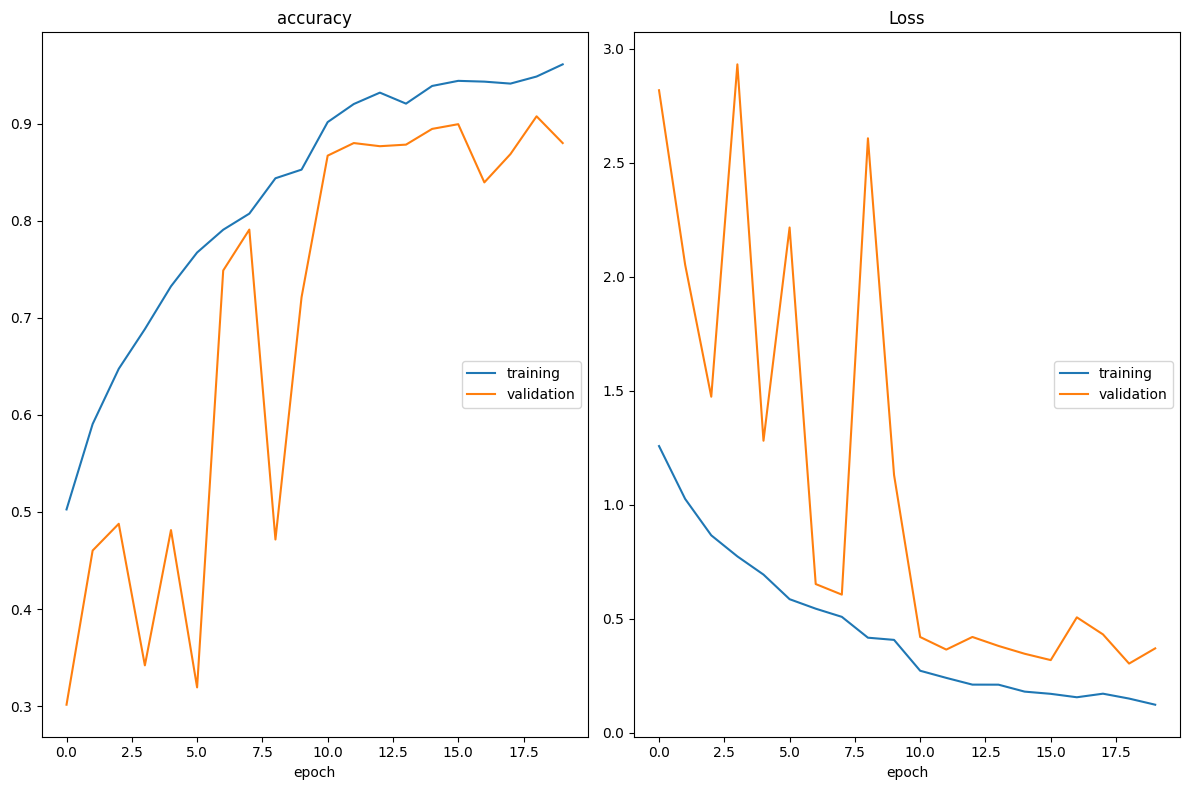

accuracy
	training         	 (min:    0.503, max:    0.961, cur:    0.961)
	validation       	 (min:    0.301, max:    0.908, cur:    0.880)
Loss
	training         	 (min:    0.122, max:    1.257, cur:    0.122)
	validation       	 (min:    0.303, max:    2.932, cur:    0.369)

Epoch 20: saving model to model_weights.h5
309/309 [==============================] - 47s 152ms/step - loss: 0.1223 - accuracy: 0.9611 - val_loss: 0.3695 - val_accuracy: 0.8801 - lr: 1.0000e-04


In [11]:
epochs=20
steps_per_epoch=train_ds.n//train_ds.batch_size
validation_steps = val_ds.n//val_ds.batch_size

checkpoint=ModelCheckpoint("model_weights.h5",monitor='val_accuracy',
                          save_weights_only=True,model='max',verbose=1)
reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=2, min_lr=0.0001,mode='auto')

callbacks=[PlotLossesKeras(),checkpoint,reduce_lr]

history = model.fit(
            x=train_ds,
             steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            validation_data=val_ds,
            callbacks=callbacks                   
)

In [13]:
model.save('final_model.h5')
